In [1]:
using CSV
using DataFrames

# Load the CSV file into a DataFrame
wine_data = CSV.read("data/winequality-white.csv", DataFrame)
#println(wine_data);

Row,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
2,6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6
3,8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.4,9.9,6
5,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.4,9.9,6
6,8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6
7,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
8,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
9,6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6


In [2]:
include("src/qsrfe.jl")

Main.qsrfe

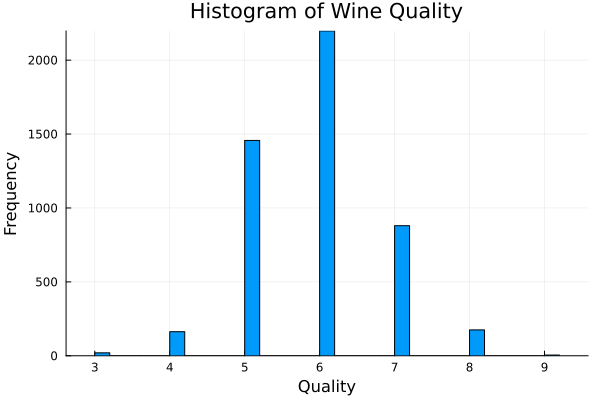

In [3]:
using Plots

# Plot histogram of the quality column
histogram(wine_data.quality, title="Histogram of Wine Quality", xlabel="Quality", ylabel="Frequency", label="")

In [ ]:
using MLJ

# Define the features and target variable
X = select(wine_data, Not(:quality))
y = wine_data.quality

# Partition the data into training (70%) and testing (30%) sets
train, test = partition(eachindex(y), 0.7, shuffle=true)

X_train = X[train, :]
y_train = y[train]
X_test = X[test, :]
y_test = y[test]
# Convert the training and testing sets into matrices and vectors
xtrain = Matrix(X_train)
ytrain = Vector(y_train)
xtest = Matrix(X_test)
ytest = Vector(y_test)

# Remove half of the elements that have ytrain = 6
indices_to_remove = findall(y -> y == 6, ytrain)
indices_to_remove = indices_to_remove[1:div(length(indices_to_remove), 2)]

xtrain = xtrain[setdiff(1:end, indices_to_remove), :]
ytrain = ytrain[setdiff(1:end, indices_to_remove)]





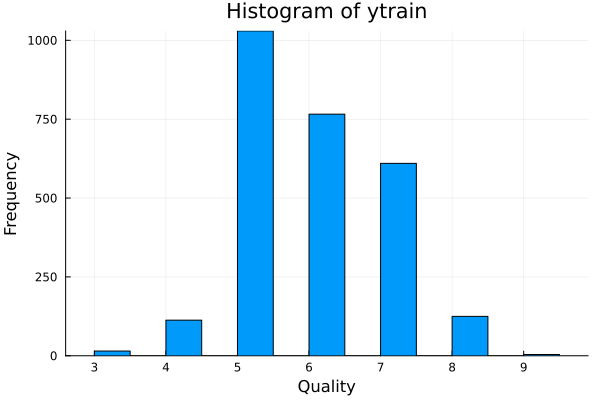

In [91]:
histogram(ytrain, title="Histogram of ytrain", xlabel="Quality", ylabel="Frequency", label="")

In [96]:
#test cell for hyperparameter testing
#model = model
N= 2^14
λ = 0.161313#srfe
#λ = 0.00004
model = qsrfe.rfeRegressor(N=N,λ=λ, σ2=0.142681,intercept=true)

c = qsrfe.fit(model,xtrain,ytrain;verbose=true)
ytrainpred = qsrfe.predict(model,xtrain)
ytestpred = qsrfe.predict(model,xtest);

println("")
println("rel L2: ",qsrfe.rel_L2_error(ytest,ytestpred)," train rel: ",qsrfe.rel_L2_error(ytrain,ytrainpred))
println("abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))
println("rel mse: ",qsrfe.rel_mse(ytest,ytestpred)," rel train mse: ",qsrfe.rel_mse(ytrain,ytrainpred))

support: 16385/16385
rel L2: 0.13383621694010314 train rel: 0.09801367888552412
abs: 0.6157591141005558 train abs: 0.4410534952813561
mse: 0.6341431580002368 train mse: 0.33723671917756337
rel mse: 0.13383621694010314 rel train mse: 0.09801367888552412


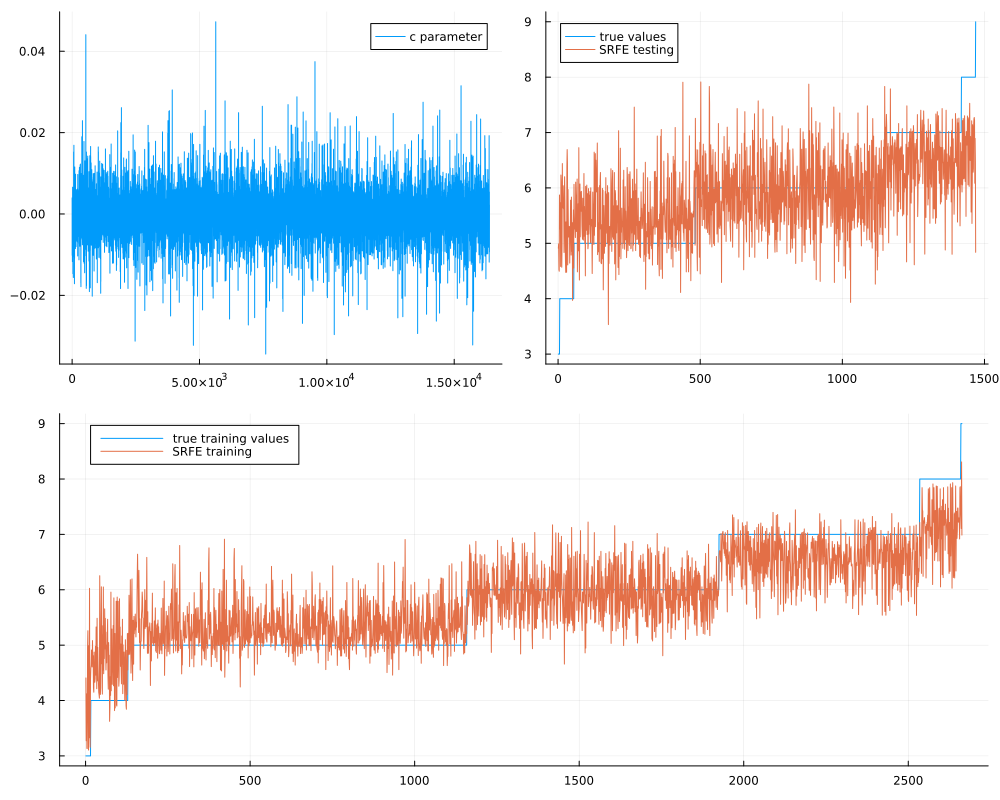

In [97]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [81]:
using HyperTuning
function objective(trial)
    @unpack λ, σ2 = trial
    model = qsrfe.rfeRegressor(N=2^13,λ=λ, σ2=σ2,intercept=true)
    c = qsrfe.fit(model,xtrain,ytrain;verbose=false)
    ytestpred = qsrfe.predict(model,xtest)
    return qsrfe.mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.000001..0.9),
                        σ2 = (1.0..100.0),
                        max_trials = 60 );

HyperTuning.optimize(objective, scenario)

Scenario: evaluated 60 trials.
          parameters: λ, σ2
   space cardinality: Huge!
           instances: 1
          batch_size: 32
             sampler: BCAPSampler{Random.Xoshiro}
              pruner: NeverPrune
          max_trials: 60
           max_evals: 60
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬──────────┐
│     Trial │    Value │
│        37 │          │
├───────────┼──────────┤
│         λ │ 0.661512 │
│        σ2 │      1.0 │
│    Pruned │    false │
│   Success │    false │
│ Objective │ 0.658043 │
└───────────┴──────────┘


In [82]:
using HyperTuning
function objective(trial)
    @unpack λ, σ2 = trial
    model = qsrfe.rfeRegressor(N=2^13,λ=λ, σ2=σ2,intercept=true)
    c = qsrfe.fit(model,xtrain,ytrain;verbose=false)
    ytestpred = qsrfe.predict(model,xtest)
    return qsrfe.mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.001..1.9),
                        σ2 = (0.01..5.0),
                        max_trials = 60 );

HyperTuning.optimize(objective, scenario)

Scenario: evaluated 60 trials.
          parameters: λ, σ2
   space cardinality: Huge!
           instances: 1
          batch_size: 32
             sampler: BCAPSampler{Random.Xoshiro}
              pruner: NeverPrune
          max_trials: 60
           max_evals: 60
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬──────────┐
│     Trial │    Value │
│        24 │          │
├───────────┼──────────┤
│         λ │ 0.761313 │
│        σ2 │ 0.142681 │
│    Pruned │    false │
│   Success │    false │
│ Objective │ 0.596474 │
└───────────┴──────────┘


In [80]:
5*60 / 5

60.0